### Analyse et comprehension des fichiers

In [1]:
import matplotlib.pyplot as plt
from read_data import *
from utils import *
from fasttext_utils import *
from sklearn.model_selection import train_test_split
import fasttext

**distribution des données**

In [2]:
train,n_train = get_train_data()
test,n_test = get_test_data()

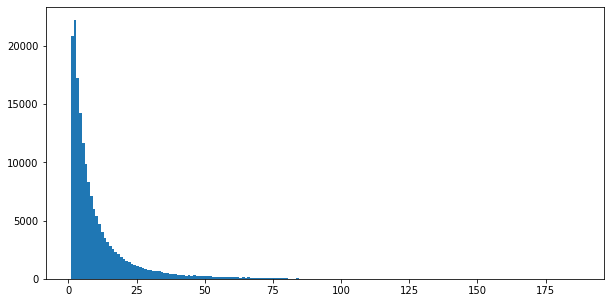

In [3]:
plt.figure(figsize=(10,5))
plt.hist(x=train['hindex'],bins=187);

**selection of sub-dataset with same distribution than the original**

**Tout le dataset (Préalablement enregistré en csv)**

In [4]:
# store_whole_dataset(train) # si tu n'as pas encore tout le dataset en local

In [5]:
# l =[]
# for i in range (18):
#     l.append(pd.read_csv("../tmp/data_part"+str(i+1)+".csv"))

# data = pd.concat(l)
# data = small_class(data, 6)
# data.head()

**Juste 10000 données**

In [6]:
data_path = "../tmp/data_10000.csv"
# data = preprocessing_for_fastText(10000,train)
# data.to_csv(data_path,index=None)
data = pd.read_csv(data_path)
data = small_class(data, 6)
data.head()

,author,hindex,text,nb_paper,mean_coauthors_hindex,n_coauthors,modindx,hindex_lab
0,1969133319,60.0,NaN,0,43.775934,241,5,__label__5
1,2192797973,15.0,we present newly collected data set of gold st...,5,12.000000,6,0,__label__0
2,2568812976,4.0,problem to be solved to provide tv system for ...,5,16.500000,2,1,__label__1
3,2159374572,24.0,this paper presents novel engine coined topx f...,5,16.716981,53,0,__label__0
4,2745744053,22.0,this paper describes coherent optical orthogon...,5,16.000000,4,0,__label__0


In [7]:
data.describe()

,author,hindex,nb_paper,mean_coauthors_hindex,n_coauthors,modindx
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.994911e+09,10.137600,3.896200,15.757368,12.532600,1.855400
std,6.398140e+08,12.814394,1.425563,11.463405,55.682089,1.506824
min,1.139156e+07,1.000000,0.000000,1.000000,0.000000,0.000000
25%,2.019859e+09,3.000000,3.000000,8.000000,2.000000,1.000000
50%,2.134432e+09,6.000000,5.000000,12.666667,3.000000,1.000000
75%,2.288160e+09,12.000000,5.000000,20.000000,6.000000,4.000000
max,2.908001e+09,163.000000,5.000000,131.000000,1209.000000,5.000000


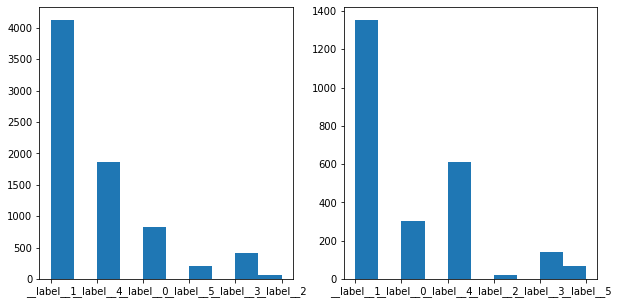

In [8]:
train1,test1 = train_test_split(data,random_state=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train1['hindex_lab'])
plt.subplot(1,2,2).hist(test1['hindex_lab']);

In [9]:
train_path = "../tmp/train1.txt"
test_path = "../tmp/test1.txt"

df_to_txt(train1,train_path)
df_to_txt(test1,test_path)

### Utilisation de Fast text

Les paramètre optimaux ont été optimisés pour 10000 données dans un autre jupyter avec un temps long. Le model 1 nest plus nécessaire!

In [10]:
model0 = fasttext.train_supervised(train_path,lr = 0.626905, dim = 12, epoch = 11, wordNgrams =3)

Read 4M words
Number of words:  67976
Number of labels: 6
Progress: 100.0% words/sec/thread: 2629841 lr:  0.000000 avg.loss:  1.213330 ETA:   0h 0m 0s


In [11]:
# train_duration = 60 # in seconds
# model1 = fasttext.train_supervised(train_path, autotuneValidationFile=test_path, autotuneDuration=train_duration)

In [12]:
model0.test(test_path)

(2500, 0.5468, 0.5468)

In [13]:
# model1.test(test_path)

In [14]:
# comp = pd.DataFrame({'paramètre':['hidden layer','learning rate','epoch','loss'],'model0':[model0.dim,model0.lr,model0.epoch,model0.loss],'model1':[model1.dim,model1.lr,model1.epoch,model1.loss]})
# comp

In [15]:
# comp =general_comp(model1,test1)
# comp.head()

**exploitation de model**

On est sur que le modèle applique softmax sur la représentation du mot. Nous ou choisit donc d'appliquer un autre régresseur

**Data for multiple regression model**

In [16]:
train_core_number = get_core_number(train1["author"])
test_core_number = get_core_number(test1["author"])

train_min_coauthor_hindex = get_min_coauthor_hindex(train1["author"])
test_min_coauthor_hindex = get_min_coauthor_hindex(test1["author"])

train_max_coauthor_hindex = get_max_coauthor_hindex(train1["author"])
test_max_coauthor_hindex = get_max_coauthor_hindex(test1["author"])

X_train,y_train = format_data(train1, model0, train_core_number, train_min_coauthor_hindex, train_max_coauthor_hindex)
X_test, y_test = format_data(test1, model0, test_core_number, test_min_coauthor_hindex, test_max_coauthor_hindex)

**Random forest**

In [17]:
print(X_train.shape)

(7500, 18)


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [19]:
mod_preds = forest_model.predict(X_test)

In [20]:
mean_squared_error(y_test,mod_preds)

78.83720061031111

**XG_BOOST**

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

model_xg = XGBRegressor(learning_rate=0.01, max_depth=5, objective="reg:linear", subsample=0.7, n_estimators=500)

In [22]:
model_xg.fit(X_train,y_train)

[02:50:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [23]:
mod_preds = model_xg.predict(X_test)
mean_squared_error(y_test,mod_preds)

76.91744751218715

**test linear regression**

In [24]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)

In [25]:
reg_pred = reg.predict(X_test)

In [26]:
mean_squared_error(y_test,reg_pred)

94.97279411669129

**test svm**

In [27]:
from sklearn.svm import SVC

model_svm =SVC(kernel='sigmoid', C=2)

In [28]:
model_svm.fit(X_train,y_train)

SVC(C=2, kernel='sigmoid')

In [29]:
svm_pred = model_svm.predict(X_test)

KeyboardInterrupt: 

In [ ]:
mean_squared_error(y_test,svm_pred)

155.67465894997932

**Test CNN**

In [ ]:
# mlp = MLP

# Soumission

In [30]:
from submit import submit
from xgboost import XGBRegressor

model_xg = XGBRegressor(learning_rate=0.01, max_depth=5, objective="reg:linear", subsample=0.7, n_estimators=500)
submit(model_xg)

43560


Read 99M words
Number of words:  360001
Number of labels: 6
Progress: 100.0% words/sec/thread: 2612463 lr:  0.000000 avg.loss:  1.292929 ETA:   0h 0m 0s
